
# Network structure: Community organization

Francisco Aparecido Rodrigues, francisco@icmc.usp.br.
Universidade de São Paulo, São Carlos, Brasil.
https://sites.icmc.usp.br/francisco
Copyright: Creative Commons

In this lecture we show how to find communities in networks. We consider several methods, networks and also bechmarks to generate networks with community structure.

Initially, we have to import the packages necessary for the network processing and visualization.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
np.random.seed(50)

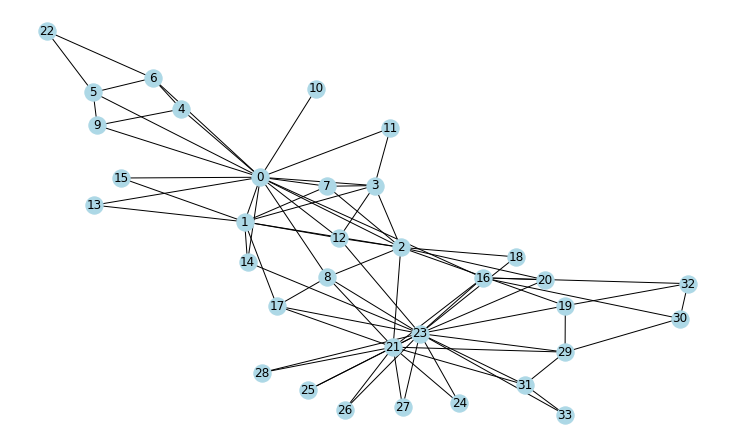

In [2]:
G= nx.read_edgelist("data/zachary.txt", nodetype=int)
nodes_original = G.nodes
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
G = nx.convert_node_labels_to_integers(G, first_label=0)

#G=nx.karate_club_graph() # we can also use the networkx dataset
pos=nx.spring_layout(G)
fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'lightblue', with_labels = True)
plt.show(True)

In [3]:
print('Original:', nodes_original)
print('New labels:', G.nodes)

Original: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31, 30, 9, 27, 28, 32, 16, 33, 14, 15, 18, 20, 22, 23, 25, 29, 24, 26]
New labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [4]:
N = len(G)
M = G.number_of_edges()
print('Number of nodes:', N)
print('Number of edges:', M)

Number of nodes: 34
Number of edges: 78



## Methdos for community identification

Let us study some methods for community identification. We consider only methods provided by the Networkx library, althoug there are many methods in the literature and some executable softwares (see https://arxiv.org/abs/1608.00163).

### Method based on the betweenness centrality

The Girvan-Newman method is based on the edge betweeneess centrality measure.

Applying the method in the Zachary karate club network.


In [5]:
#Girvan-Newman method (betweenness centrality)
communities = community.centrality.girvan_newman(G)
k = 2
for i in range(0, k-1):
    next_level_communities = next(communities)
c = sorted(map(sorted, next_level_communities))
for cl in c:
    print('community:', cl)

community: [0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 22]
community: [2, 8, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


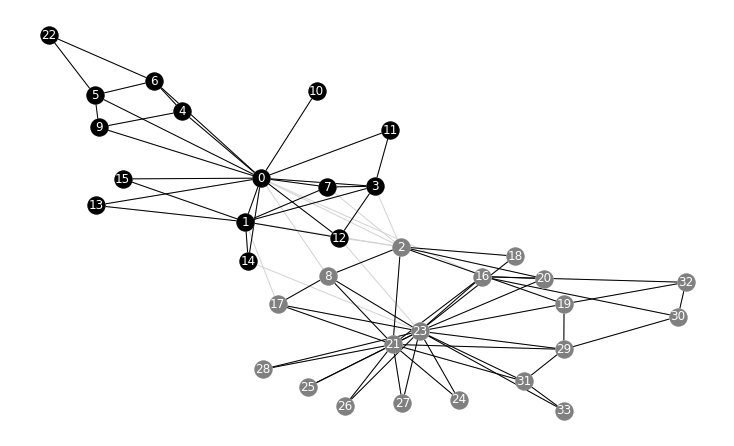

In [6]:
colors = ['black', 'gray', 'green', 'c', 'm', 'y', 'w']

fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'white', edge_color='lightgray')
aux = 0
for cm in c:
    nx.draw(G.subgraph(cm), pos=pos, node_color = colors[aux], 
                     with_labels = True, node_size=300, font_color = 'white')
    aux = aux + 1
plt.savefig('Zachary.eps') #save the figure into a file
plt.show(True)

The respective dendrogram.

<Figure size 432x288 with 0 Axes>

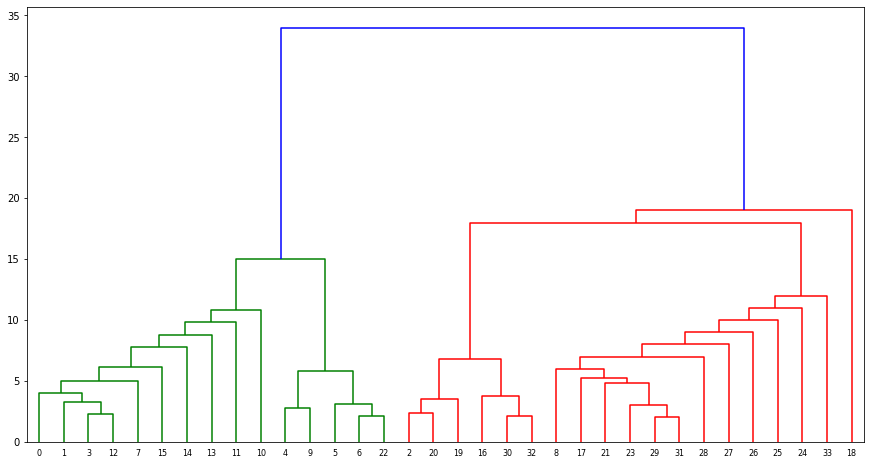

In [7]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

communities = list(community.centrality.girvan_newman(G))

# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format 
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

# a function to get a merge height so that it is unique
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

G           = nx.DiGraph(node_id_to_children)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

# dendrogram
plt.figure()
fig= plt.figure(figsize=(15,8))
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves], leaf_rotation=0)
plt.savefig('dendrogram.eps')



### Fast greedy algorithm

Let us find communities by using Clauset-Newman-Moore greedy modularity maximization.


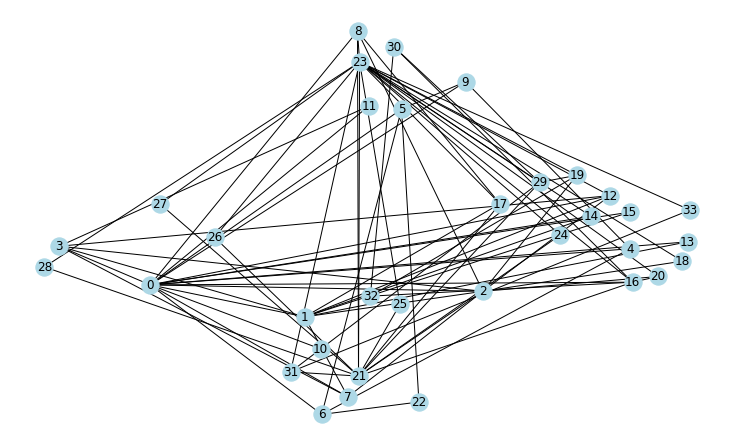

In [35]:
G= nx.read_edgelist("data/zachary.txt", nodetype=int)
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
G = nx.convert_node_labels_to_integers(G, first_label=0)


fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'lightblue', with_labels = True)
plt.show(True)

In [36]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G))
for k in range(0,len(communities)):
    print('Community',k,':', sorted(communities[k]))

Community 0 : [8, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community 1 : [1, 2, 3, 7, 11, 12, 13, 15, 18]
Community 2 : [0, 4, 5, 6, 9, 10, 14, 22]


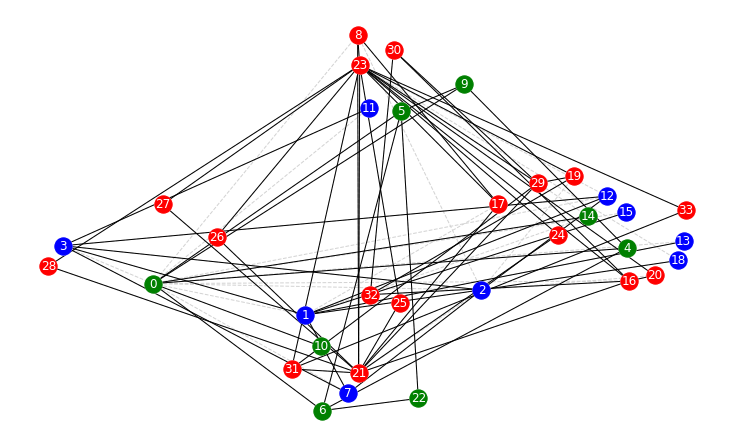

In [37]:
colors = ['red', 'blue', 'green', 'black', 'magenta', 'yellow', 'white']

fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'white', edge_color='lightgray', style='dashed')
aux = 0
for cm in communities:
    nx.draw(G.subgraph(cm), pos=pos, node_color = colors[aux], 
                     with_labels = True, node_size=300, font_color = 'white')
    aux = aux + 1
plt.savefig('Zachary.eps') #save the figure into a file
plt.show(True)


### Louvain Method

To install the Louvain method, you can use: pip install python-louvain. See also: https://github.com/taynaud/python-louvain. A test of the package can be done by running the code available at: http://python-louvain.readthedocs.io/en/latest/

To install, type in a terminal:
pip install community
pip install python-louvain

In [12]:
import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

Let us read and draw the network again.

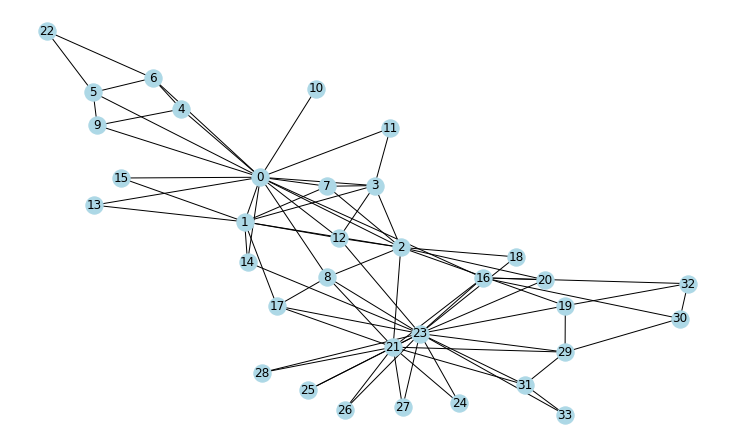

In [13]:
G= nx.read_edgelist("data/zachary.txt", nodetype=int)
#G=nx.karate_club_graph() # we can also use the networkx dataset
G = G.to_undirected()
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
G = nx.convert_node_labels_to_integers(G, first_label=0)

fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'lightblue',with_labels=True)
plt.show(True)



The Louvain method: (it it does not work, try: pip3 install --upgrade networkx)


In [14]:
from community import community_louvain
partitions =community_louvain.best_partition(G)

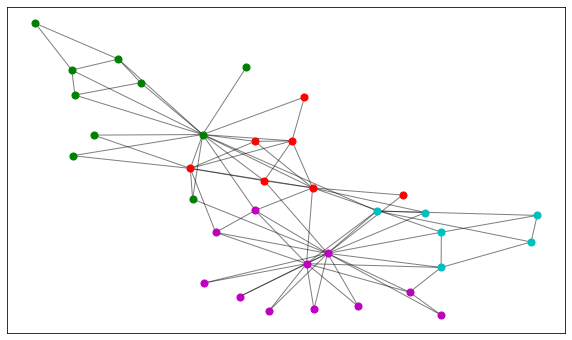

In [15]:
#drawing
fig= plt.figure(figsize=(10,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(partitions.values())))
count = 0
for com in set(partitions.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partitions.keys() if partitions[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

We can also consider the random network with community structure.

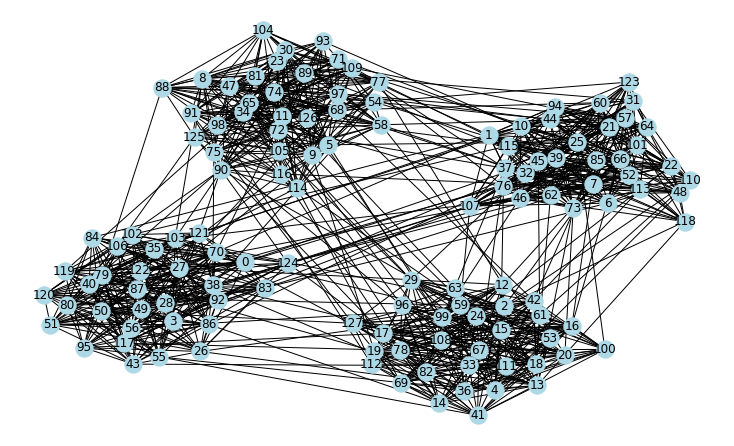

In [17]:
N = 128
tau1 = 3
tau2 = 1.5
mu = 0.04
k =16
minc = 32
maxc = 32
G = nx.LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 10)
pos=nx.spring_layout(G)
fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'lightblue', with_labels = True)
plt.show(True)



Applying the Louvain method.


In [18]:
partition = community_louvain.best_partition(G)

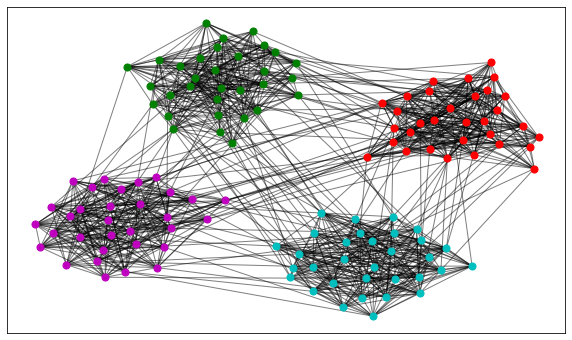

In [19]:
#drawing
fig= plt.figure(figsize=(10,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
size = float(len(set(partition.values())))
count = 0
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 50, node_color = colors[int(count)])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()


## Modularity measure


In [20]:
from networkx.algorithms.community import greedy_modularity_communities

#G= nx.read_edgelist("data/zachary.txt", nodetype=int)
G=nx.karate_club_graph()

c = list(greedy_modularity_communities(G))
communities = np.zeros(len(G.nodes()))
nc = 0
for k in range(0,len(c)):
    communities[sorted(c[k])]=nc
    nc = nc+1
    print('Community:', sorted(c[k]))

Community: [8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community: [1, 2, 3, 7, 9, 12, 13, 17, 21]
Community: [0, 4, 5, 6, 10, 11, 16, 19]




The modularity for the obtained partition:


In [21]:
def modularity(G, c):
    A = nx.adjacency_matrix(G)
    N = len(G)
    M = G.number_of_edges()
    Q = 0
    for i in np.arange(0,N):
        ki = len(list(G.neighbors(i)))
        for j in np.arange(0,N):
            if(c[i]==c[j]):
                kj = len(list(G.neighbors(j)))
                Q = Q + A[i,j]-(ki*kj)/(2*M)
    Q = Q/(2*M)
    return Q

In [22]:
print("Modularity Q = ", modularity(G,communities))

Modularity Q =  0.3806706114398406


## Communities in random network: Can we find them?


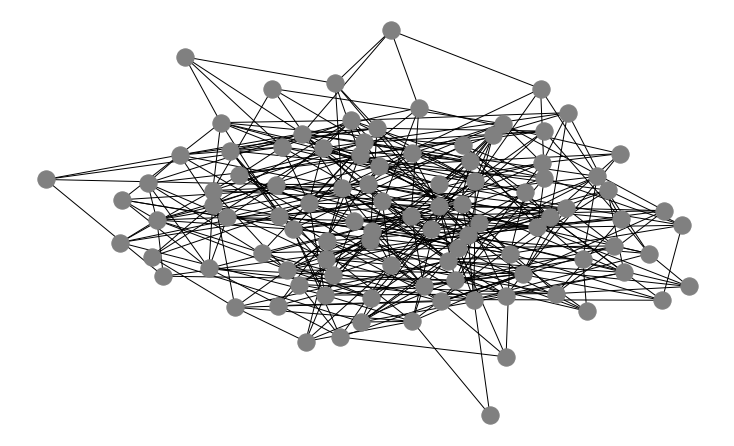

In [23]:
N = 100
av_degree = 8
p = av_degree/(N-1)
G = nx.gnp_random_graph(N, p, seed=None, directed=False)
pos=nx.nx.fruchterman_reingold_layout(G)
fig= plt.figure(figsize=(10,6))
nx.draw(G, pos=pos, node_color = 'gray', with_labels=False)
plt.savefig('ER-com1.eps') #save the figure into a file
plt.show(True)

In [24]:
from networkx.algorithms.community import greedy_modularity_communities

c = list(greedy_modularity_communities(G))
communities = np.zeros(len(G.nodes()))
nc = 0
for k in range(0,len(c)):
    communities[sorted(c[k])]=nc
    nc = nc+1
    print('Community:', sorted(c[k]))

Community: [2, 5, 6, 8, 10, 22, 23, 32, 33, 37, 41, 43, 45, 55, 57, 60, 68, 69, 77, 78, 82, 87, 99]
Community: [0, 1, 16, 17, 18, 19, 20, 27, 28, 35, 38, 46, 47, 49, 56, 58, 74, 75, 79, 93, 96, 98]
Community: [3, 9, 11, 14, 15, 21, 24, 26, 39, 40, 42, 53, 64, 81, 89, 91]
Community: [4, 7, 12, 13, 30, 34, 44, 48, 51, 52, 54, 59, 65, 71, 88, 92]
Community: [25, 29, 31, 61, 63, 73, 76, 84, 85, 86, 90, 94, 95, 97]
Community: [36, 50, 62, 66, 67, 70, 72, 80, 83]


<Figure size 432x288 with 0 Axes>

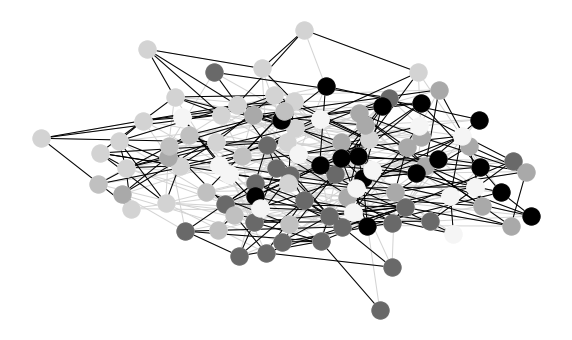

In [25]:
colors = ['dimgray', 'lightgray', 'darkgray', 'black', 'whitesmoke', 'silver','gray','grey']

plt.figure()
fig= plt.figure(figsize=(10,6))
nx.draw_networkx(G, pos=pos, node_color = 'white', edge_color='lightgray', with_labels = False)
aux = 0
for cm in c:
    nx.draw(G.subgraph(cm), pos=pos, node_color = colors[aux], 
                     with_labels = False, node_size=300, font_color = 'white')
    aux = aux + 1
plt.savefig('ER-com2.eps') #save the figure into a file
plt.show(True)

In [26]:
print("Modularity Q = ", modularity(G,communities))

Modularity Q =  0.30816949676621497



### Benchmarks

Let us now see how to generate a network with community structure and find the communities.

One of the most popular method to generate networks with community structure was proposed by Girvan and Newman, which is a type of planted partition model.


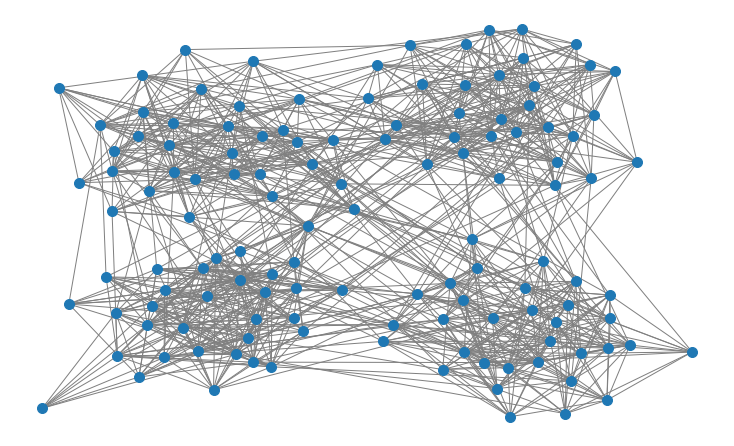

In [28]:
fig= plt.figure(figsize=(10,6))

k=16
kout = 3
kin = k - kout
pin = kin/32
pout = kout/(128-32)
G = nx.random_partition_graph([32,32,32,32],pin,pout)
pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, edge_color='gray', 
        node_size=100, font_size=16,  width=1, pos = pos)
plt.show(True)

We can also use the algorithm by Lancichinetti et al., PRE, 2008. See: https://arxiv.org/abs/0805.4770

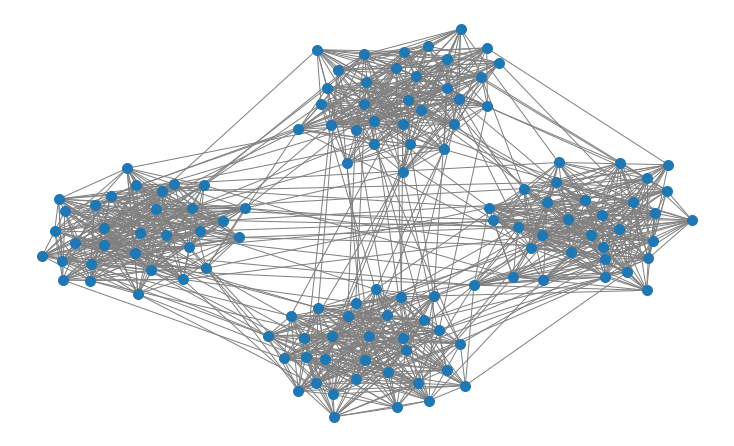

In [29]:
fig= plt.figure(figsize=(10,6))

N = 128
tau1 = 3
tau2 = 1.5
mu = 0.05
k =16
minc = 32
maxc = 32
G = nx.LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc, seed = 10)
pos=nx.spring_layout(G)
nx.draw(G, with_labels = False, edge_color='gray', 
        node_size=100, font_size=16,  width=1, pos = pos)
plt.show(True)

In [30]:
c = {frozenset(G.nodes[v]['community']) for v in G}
communities = np.zeros(len(G.nodes()))
cl = 0
for a in c:
    b = list(a)
    communities[b] = cl
    #print(cl,':',sort(b))
    cl = cl + 1
print(communities)

[3. 2. 1. 3. 1. 0. 2. 2. 0. 0. 2. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 0.
 1. 2. 3. 3. 3. 1. 0. 2. 2. 1. 0. 3. 1. 2. 3. 2. 3. 1. 1. 3. 2. 2. 2. 0.
 2. 3. 3. 3. 2. 1. 0. 3. 3. 2. 0. 1. 2. 1. 2. 1. 2. 0. 2. 1. 0. 1. 3. 0.
 0. 2. 0. 0. 2. 0. 1. 3. 3. 0. 1. 3. 3. 2. 3. 3. 0. 0. 0. 0. 3. 0. 2. 3.
 1. 0. 0. 1. 1. 2. 3. 3. 0. 0. 3. 2. 1. 0. 2. 1. 1. 2. 0. 2. 0. 3. 2. 3.
 3. 3. 3. 2. 3. 0. 0. 1.]


In [31]:
print("Modularity Q = ", modularity(G,communities))

Modularity Q =  0.643639535397838




Let us use the Girvan-Newman method again.


In [32]:
#Girvan-Newman method (betweenness centrality)
communities = community.girvan_newman(G)
k = 4
for i in range(0, k-1):
    next_level_communities = next(communities)
c = sorted(map(sorted, next_level_communities))
for cl in c:
    print('community:', cl)

community: [0, 3, 26, 27, 28, 35, 38, 40, 43, 49, 50, 51, 55, 56, 70, 79, 80, 83, 84, 86, 87, 92, 95, 102, 103, 106, 117, 119, 120, 121, 122, 124]
community: [1, 6, 7, 10, 21, 22, 25, 31, 32, 37, 39, 44, 45, 46, 48, 52, 57, 60, 62, 64, 66, 73, 76, 85, 94, 101, 107, 110, 113, 115, 118, 123]
community: [2, 4, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 29, 33, 36, 41, 42, 53, 59, 61, 63, 67, 69, 78, 82, 96, 99, 100, 108, 111, 112, 127]
community: [5, 8, 9, 11, 23, 30, 34, 47, 54, 58, 65, 68, 71, 72, 74, 75, 77, 81, 88, 89, 90, 91, 93, 97, 98, 104, 105, 109, 114, 116, 125, 126]




And plotting the results.


<Figure size 720x432 with 0 Axes>

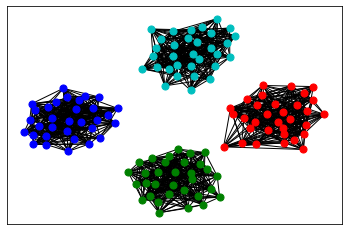

In [33]:
fig= plt.figure(figsize=(10,6))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure()
aux = 0
for cm in c:
    nx.draw_networkx(G.subgraph(cm), pos=pos, node_color = colors[aux], with_labels = False, node_size=50)
    aux = aux + 1
plt.show(True)